The MIT License (MIT)

Copyright (c) 2019 Institute for Molecular Systems Biology, ETH Zurich

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [1]:
import argparse
import logging
import os
import re
import numpy as np
from typing import Iterable, Tuple
from cobra.io import read_sbml_model
import pandas as pd
from sbtab import SBtab
from equilibrator_api import Q_, ComponentContribution
import pydot
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [2]:
sys.path.append("..")
from src import EXAMPLE_PATH, RES_PATH, REC_PATH, Solution, MDF

In [3]:
# display the allowed concentration ranges used in the MILP (Table X1)

CONC_BOUNDS_FNAME = os.path.join(REC_PATH, "co2_to_pyr_concentration.csv")
conc_bounds_df = pd.read_csv(CONC_BOUNDS_FNAME, index_col=0)
conc_bounds_df

Compound    Compound:Identifiers Concentration:Min Concentration:Max
1      h2o_c     bigg.metabolite:h2o               1 M               1 M
2      atp_c     bigg.metabolite:atp              5 mM              5 mM
3      adp_c     bigg.metabolite:adp            0.5 mM            2.5 mM
4      amp_c     bigg.metabolite:amp            0.5 mM            2.5 mM
5      nad_c     bigg.metabolite:nad              1 mM              1 mM
6     nadh_c    bigg.metabolite:nadh             10 uM            100 uM
7    nadph_c   bigg.metabolite:nadph             10 uM            100 uM
8     nadp_c    bigg.metabolite:nadp             10 uM             10 uM
9       o2_c      bigg.metabolite:o2            273 uM            273 uM
10     co2_c     bigg.metabolite:co2            6.8 mM            6.8 mM
11      pi_c      bigg.metabolite:pi              1 mM             10 mM
12     coa_c     bigg.metabolite:coa              1 mM              5 mM
13     ppi_c     bigg.metabolite:ppi            0.5 mM            1.5 mM
14     nh4_c     bigg.metabolite:nh4              1 mM             10 mM
15     akg_c     bigg.metabolite:akg            0.5 mM              5 mM
16  glu__L_c  bigg.metabolite:glu__L             30 mM            150 mM
17     fe2_c     bigg.metabolite:fe2              1 uM             10 mM
18     fe3_c     bigg.metabolite:fe3              1 uM             10 mM
19     udp_c     bigg.metabolite:udp              1 uM             10 mM
20   flxso_c   bigg.metabolite:flxso              1 uM             10 mM
21    flxr_c    bigg.metabolite:flxr              1 uM             10 mM
22   trdox_c   bigg.metabolite:trdox              1 uM             10 mM
23   trdrd_c   bigg.metabolite:trdrd              1 uM             10 mM
24      q8_c      bigg.metabolite:q8              1 uM             10 mM
25    q8h2_c    bigg.metabolite:q8h2              1 uM             10 mM
26    mql8_c    bigg.metabolite:mql8              1 uM             10 mM
27    mqn8_c    bigg.metabolite:mqn8              1 uM             10 mM
28     fad_c     bigg.metabolite:fad              1 uM             10 mM
29   fadh2_c   bigg.metabolite:fadh2              1 uM             10 mM

In [4]:
cobra_model = read_sbml_model(os.path.join(REC_PATH, "iML1515.xml.gz"))
bounds_df = pd.read_csv(os.path.join(REC_PATH, "co2_to_pyr_concentration.csv"))
comp_contrib = ComponentContribution()
comp_contrib.p_h = Q_(7.5)
comp_contrib.ionic_strength = Q_("0.3 M")

cofactors = set(map(cobra_model.metabolites.get_by_id, [
    "adp_c", "atp_c", "co2_c", "o2_c", "pi_c", "nh4_c", "glu__L_c",
    "akg_c", "h_c", "h_p", "h_e", "h2o_c", "nad_c", "nadh_c",
    "nadp_c", "nadph_c", "trdox_c", "trdrd_c", "q8_c", "q8h2_c", "mqn8_c", "mql8_c"
]))

Fragments already downloaded
Fragments already downloaded


In [5]:
# collect the stats from the solution file
stats_data = []
reaction_data = []
all_reaction_ids = set()

sbtabdoc = SBtab.read_csv(f"pathways.tsv", "solutions")
for sbtab in tqdm(
    sbtabdoc.sbtabs,
    desc="Gathering stats from all pathways"
):
    if sbtab.table_type == "Reaction":
        i = int(re.findall("Pathway_(\d+)_reactions", sbtab.table_name)[0])
        d = {"pathways": i}
        for row in sbtab.to_data_frame().itertuples():
            all_reaction_ids.add(row.reaction_id)
            flux = float(row.primal)
            if flux > 0:
                d[row.reaction_id + "_F"] = flux
            elif flux < 0:
                d[row.reaction_id + "_R"] = -flux
        reaction_data.append(d)
    
    if sbtab.table_type == "Quantity":
        i = int(re.findall("Pathway_(\d+)_stats", sbtab.table_name)[0])
        df = sbtab.to_data_frame().set_index("ID")
        mdf = Q_(float(df.at["mdf", "Value"]), units=df.at["mdf", "Unit"])
        sum_of_fluxes = float(df.at["sum_flux", "Value"])
        n_reactions = float(df.at["nr", "Value"])
        stats_data.append((i, mdf, sum_of_fluxes, n_reactions))

stats_df = pd.DataFrame(
    data=stats_data,
    columns=["pathways", "mdf", r"$\Sigma |v_i|$", "n_reactions"]
).set_index("pathways")

reaction_df = pd.DataFrame.from_dict(reaction_data).set_index("pathways").fillna(0.0)

In [6]:
# DEBUG: write the list of all the reactions used in all the pathways
pd.DataFrame(data=[(rxn.id, rxn.name, rxn.reaction)
                   for rxn in map(cobra_model.reactions.get_by_id, all_reaction_ids)],
                   columns=["bigg_id", "name", "formula"]).to_csv(f"pathways_reactions.csv")
pd.merge(stats_df, reaction_df, left_index=True, right_index=True).to_csv(f"pathways_summary.csv")

In [7]:
# find the names of all the carboxylating enzymes
rxn_carb = set()
for rxn in cobra_model.metabolites.co2_c.reactions:
    if cobra_model.metabolites.co2_c in rxn.reactants:
        rxn_carb.add(rxn.id + "_F")
    elif cobra_model.metabolites.co2_c in rxn.products:
        rxn_carb.add(rxn.id + "_R")
    else:
        raise Exception("internal error")
rxn_carb = list(rxn_carb.intersection(reaction_df.columns))

In [8]:
# write the list of all carboxylases
carb_df_list = []
for co2 in [cobra_model.metabolites.co2_c, cobra_model.metabolites.hco3_c]:
    carb_df_list.append(pd.DataFrame(data=[(rxn.id, rxn.name, co2.name, rxn.reaction, co2 in rxn.reactants)
                                           for rxn in co2.reactions],
                                     columns=["bigg_id", "name", "co2_form", "formula", "forward"]))
carb_df = pd.concat(carb_df_list)

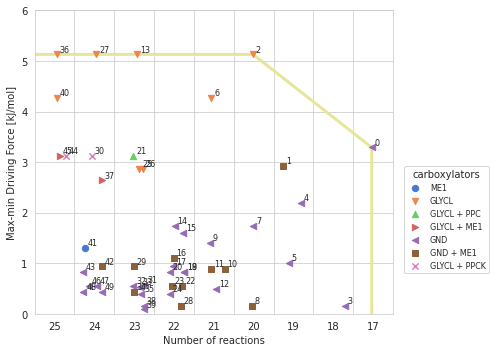

In [9]:
colors = sns.color_palette(palette="muted", n_colors=10)
markers = ["o", "v", "^", ">", "<", "s", "x", "+"] * 5

sns.set_style("whitegrid")

tmp_df = stats_df.copy()
tmp_df["y"] = stats_df.mdf.apply(lambda x: (x/Q_("kJ/mol")).magnitude)
tmp_df["x"] = stats_df.n_reactions.apply(int) + 0.6 * (np.random.rand(stats_df.shape[0]) - 0.5)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
for (group, group_df), color, marker in zip((reaction_df[rxn_carb] != 0).groupby(rxn_carb), colors, markers):
    label = " + ".join(sorted([r for r, c in zip(rxn_carb, group) if c is True]))
    label = label.replace("_R", "")
    label = label.replace("_F", "")    
    idx = group_df.index
    y = tmp_df.loc[idx, "y"]
    x = tmp_df.loc[idx, "x"]
    ax.scatter(x=x, y=y, s=40, color=color, marker=marker, label=label, alpha=1, zorder=2)
    for row in group_df.itertuples():
        ax.text(x.at[row.Index]-0.07, y.at[row.Index]+0.05, f"{row.Index}", fontsize=8)
    
maxx = int(tmp_df.n_reactions.max())
minx = int(tmp_df.n_reactions.min())
ax.set_xticks(range(minx, maxx+1))
ax.set_xlim(maxx+0.5, minx-0.5)
ax.set_ylim(0, np.ceil(tmp_df.y.max()))

for i in range(minx, maxx):
    ax.axvline(x=i+0.5, ls="-", linewidth=1, color="grey", alpha=0.3, zorder=0)
ax.xaxis.grid(False)

# depict the Pareto front somehow
pareto_y = tmp_df.sort_values(by=["y", "x"], ascending=[False, True]).iloc[0, :]
pareto_x = tmp_df.sort_values(by=["x", "y"], ascending=[True, False]).iloc[0, :]
ax.plot([tmp_df.x.min(), pareto_x.x, pareto_y.x, maxx+0.5],
        [0, pareto_x.y, pareto_y.y, tmp_df.y.max()],
        color=(0.9, 0.9, 0.6), alpha=1, linewidth=3, zorder=1)

ax.legend(title="carboxylators", fontsize=8, bbox_to_anchor=(1.02, 0.5))
ax.set_xlabel("Number of reactions")
ax.set_ylabel("Max-min Driving Force [kJ/mol]")

fig.tight_layout()
fig.savefig(f"figureX1.pdf", format="pdf")

## Draw all pathways using graphviz

In [10]:
if not os.path.exists("gdot"):
    os.mkdir("gdot")

pathway_data = []
for row in tqdm(
    stats_df.itertuples(),
    desc="Drawing pathways as PDF files",
    total=stats_df.shape[0]
):
    df = reaction_df.loc[row.Index, :].reset_index().rename(columns={"index": "reaction_id", row.Index: "primal"})
    df["type"] = "flux"
    df["lp_type"] = "variable"
    df["name"] = "R@flux@" + df.reaction_id
    df["primal"] = df.primal.apply(float)
    sol = Solution(row.Index, cobra_model, cofactors, df, row.mdf)
    g_dot, r_nodes, m_nodes = sol.to_graph()
    g_dot.write_pdf(f"gdot/pathway{row.Index:d}.pdf")

In [11]:
_df = reaction_df.loc[:, rxn_carb].copy()
_df.index.name = "pathway"
_df.columns = _df.columns.map(lambda s: s.replace("_R", "").replace("_F", ""))
_df = _df.reset_index()
_df = _df.melt(id_vars="pathway", var_name="carboxylators", value_name="flux")
_df = _df[_df.flux > 0]
_df = _df.groupby("pathway")["carboxylators"].apply(lambda text: ' + '.join(text))
stats_df = _df.to_frame().join(stats_df, on="pathway")
stats_df

carboxylators                    mdf  $\Sigma |v_i|$  n_reactions
pathway                                                                  
0                 GND  3.29 kilojoule / mole          33.000         17.0
1           GND + ME1  2.93 kilojoule / mole          37.000         19.0
2               GLYCL  5.13 kilojoule / mole          49.000         20.0
3                 GND  0.16 kilojoule / mole          35.000         18.0
4                 GND  2.19 kilojoule / mole          37.000         19.0
5                 GND  1.01 kilojoule / mole          37.000         19.0
6               GLYCL  4.27 kilojoule / mole          45.334         21.0
7                 GND  1.74 kilojoule / mole          39.000         20.0
8           GND + ME1  0.15 kilojoule / mole          38.000         20.0
9                 GND   1.4 kilojoule / mole          41.000         21.0
10          GND + ME1  0.89 kilojoule / mole          41.000         21.0
11          GND + ME1  0.89 kilojoule / mole          41.000         21.0
12                GND  0.49 kilojoule / mole          35.000         21.0
13              GLYCL  5.13 kilojoule / mole          51.000         23.0
14                GND  1.74 kilojoule / mole          43.000         22.0
15                GND   1.6 kilojoule / mole          40.000         22.0
16          GND + ME1   1.1 kilojoule / mole          38.000         22.0
17                GND  0.94 kilojoule / mole          38.000         22.0
18                GND  0.83 kilojoule / mole          40.000         22.0
19                GND  0.83 kilojoule / mole          40.000         22.0
20                GND  0.83 kilojoule / mole          40.000         22.0
21        GLYCL + PPC  3.12 kilojoule / mole          43.000         23.0
22          GND + ME1  0.55 kilojoule / mole          38.000         22.0
23          GND + ME1  0.55 kilojoule / mole          42.500         22.0
24                GND   0.4 kilojoule / mole          43.000         22.0
25              GLYCL  2.87 kilojoule / mole          51.000         23.0
26              GLYCL  2.87 kilojoule / mole          53.000         23.0
27              GLYCL  5.13 kilojoule / mole          52.334         24.0
28          GND + ME1  0.16 kilojoule / mole          45.000         22.0
29          GND + ME1  0.94 kilojoule / mole          45.000         23.0
30       PPCK + GLYCL  3.12 kilojoule / mole          42.334         24.0
31                GND  0.57 kilojoule / mole          42.000         23.0
32                GND  0.55 kilojoule / mole          45.000         23.0
33                GND  0.53 kilojoule / mole          40.000         23.0
34          GND + ME1  0.43 kilojoule / mole          44.000         23.0
35                GND   0.4 kilojoule / mole          45.000         23.0
36              GLYCL  5.13 kilojoule / mole          57.000         25.0
37        GLYCL + ME1  2.64 kilojoule / mole          45.000         24.0
38                GND  0.15 kilojoule / mole          45.000         23.0
39                GND  0.09 kilojoule / mole          47.000         23.0
40              GLYCL  4.27 kilojoule / mole          52.000         25.0
41                ME1  1.31 kilojoule / mole          63.000         24.0
42          GND + ME1  0.94 kilojoule / mole          47.000         24.0
43                GND  0.83 kilojoule / mole          44.000         24.0
44       PPCK + GLYCL  3.13 kilojoule / mole          63.000         25.0
45        GLYCL + ME1  3.12 kilojoule / mole          43.334         25.0
46                GND  0.55 kilojoule / mole          47.000         24.0
47                GND  0.55 kilojoule / mole          47.000         24.0
48                GND  0.43 kilojoule / mole          47.000         24.0
49                GND  0.43 kilojoule / mole          47.000         24.0

In [12]:
# make a LaTeX table with the pathway statistics
print("Pathway & MDF [kJ/mol] & No. reactions & Carboxylating reactions \\\\")
print("\\hline")
carb_df = reaction_df.loc[:, rxn_carb]
for row in stats_df.itertuples():
    print(f"{row.Index} & {row.mdf.magnitude} & {row.n_reactions} & {row.carboxylators}\\\\")

Pathway & MDF [kJ/mol] & No. reactions & Carboxylating reactions \\
\hline
0 & 3.29 & 17.0 & GND\\
1 & 2.93 & 19.0 & GND + ME1\\
2 & 5.13 & 20.0 & GLYCL\\
3 & 0.16 & 18.0 & GND\\
4 & 2.19 & 19.0 & GND\\
5 & 1.01 & 19.0 & GND\\
6 & 4.27 & 21.0 & GLYCL\\
7 & 1.74 & 20.0 & GND\\
8 & 0.15 & 20.0 & GND + ME1\\
9 & 1.4 & 21.0 & GND\\
10 & 0.89 & 21.0 & GND + ME1\\
11 & 0.89 & 21.0 & GND + ME1\\
12 & 0.49 & 21.0 & GND\\
13 & 5.13 & 23.0 & GLYCL\\
14 & 1.74 & 22.0 & GND\\
15 & 1.6 & 22.0 & GND\\
16 & 1.1 & 22.0 & GND + ME1\\
17 & 0.94 & 22.0 & GND\\
18 & 0.83 & 22.0 & GND\\
19 & 0.83 & 22.0 & GND\\
20 & 0.83 & 22.0 & GND\\
21 & 3.12 & 23.0 & GLYCL + PPC\\
22 & 0.55 & 22.0 & GND + ME1\\
23 & 0.55 & 22.0 & GND + ME1\\
24 & 0.4 & 22.0 & GND\\
25 & 2.87 & 23.0 & GLYCL\\
26 & 2.87 & 23.0 & GLYCL\\
27 & 5.13 & 24.0 & GLYCL\\
28 & 0.16 & 22.0 & GND + ME1\\
29 & 0.94 & 23.0 & GND + ME1\\
30 & 3.12 & 24.0 & PPCK + GLYCL\\
31 & 0.57 & 23.0 & GND\\
32 & 0.55 & 23.0 & GND\\
33 & 0.53 & 23.0 & GND\\
34 & 0